In [30]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy as sp

In [31]:
from parse import *

## Randomly remove edges

In [32]:
Gg = read_input_file("inputs/small/small-1.in")

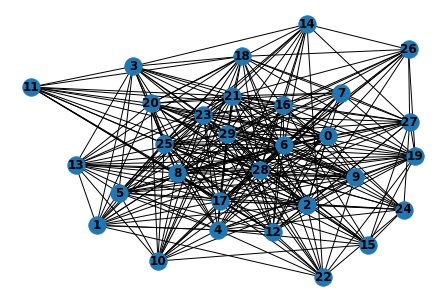

In [33]:
nx.draw(Gg, with_labels=True, font_weight='bold')

In [34]:
l = len(list(Gg.edges))
l

292

In [35]:
sp.special.binom(l, l - 15)

5.074866030134501e+24

In [36]:
nx.dijkstra_path_length(Gg, 0, 29)

25.282

In [37]:
def rem_random(G, k):
    """
    G: graph input
    k: number of random graphs to consider
    """
    v = G.number_of_nodes() - 1
    path = nx.dijkstra_path(G, 0, v)
    longest_min_path = nx.dijkstra_path_length(G, 0, v)
    rm_edges = 0
    rm_node = 0
    
    nodes = np.sort(list(G.nodes))[1:][:-1]
    
    for n in nodes:
        G_prime = nx.Graph(G)
        G_prime.remove_node(n)
        
        G_prime_edges = list(G_prime.edges)
        
        for _ in range(k):
            to_remove = random.sample(G_prime_edges, 15)
            G_prime.remove_edges_from(to_remove)
            
            if nx.is_connected(G_prime):
                new_min_path = nx.dijkstra_path_length(G_prime, 0, v)
        
                if new_min_path > longest_min_path:
                    longest_min_path = new_min_path
                    rm_edges = to_remove
                    path = nx.dijkstra_path(G_prime, 0, v)
                    rm_node = n
            
    return path, longest_min_path, rm_edges, rm_node

In [38]:
r = rem_random(Gg, 50000)
r

([0, 21, 7, 17, 26, 29],
 198.658,
 [(20, 23),
  (2, 0),
  (11, 17),
  (0, 27),
  (3, 14),
  (15, 20),
  (0, 20),
  (4, 10),
  (5, 8),
  (4, 5),
  (1, 28),
  (22, 23),
  (12, 29),
  (19, 28),
  (1, 8)],
 25)

In [39]:
Gg2 = read_input_file("inputs/small/small-8.in")

In [40]:
r2 = rem_random(Gg2, 50000)
r2

([0, 28, 16, 4, 22, 9, 1, 29],
 314.0,
 [(0, 16),
  (19, 12),
  (6, 15),
  (15, 12),
  (3, 17),
  (24, 4),
  (20, 10),
  (0, 18),
  (11, 26),
  (14, 26),
  (16, 29),
  (27, 14),
  (2, 25),
  (0, 21),
  (15, 26)],
 5)

This graph has 30 nodes and 111 edges


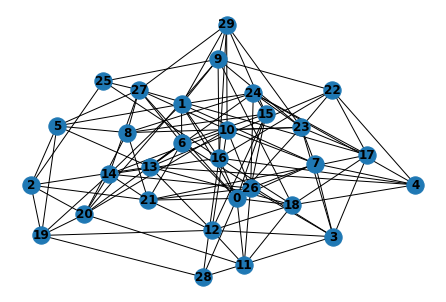

In [41]:
print("This graph has", Gg2.number_of_nodes(), "nodes and", Gg2.number_of_edges(), "edges")

nx.draw(Gg2, with_labels=True, font_weight='bold');

In [29]:
nx.dijkstra_path_length(Gg2, 0, 29)

34.0